# LSTM for Text Classification

*Homework by Samoshyn Andriy*

In [1]:
# import resources
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import spacy
import string
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


In [4]:
train_df = pd.read_csv('../input/yelp-reviews-dataset/train.csv', header=None, names=['rating', 'review'])#.iloc[:325000, :]
test_df = pd.read_csv('../input/yelp-reviews-dataset/test.csv', header=None, names=['rating', 'review'])#.iloc[:25000, :]

Before working with the data, you need to do some basic cleanup. The text contains many characters that will prevent the model from learning correctly.

In [5]:
def preproc(df):
    df['review_length'] = df['review'].apply(lambda x: len(x.split()))
    zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
    df['rating'] = df['rating'].apply(lambda x: zero_numbering[x])
    df['review'] = df['review'].apply(lambda x: x.replace('\\n', ''))
    print("df['review'] del '@-.;,' done!")
    df['review'] = df['review'].apply(lambda x: re.sub(r"[^a-z\s]", '', x.lower()))
    print(f"df['review'] delete bad symbols done!")
        
    df['review'] = df['review'].apply(lambda x: re.sub(r"\s{2,}"," ", x))
    print(f"df['review'] delete lot's of spaces done!")

    
    return df

In [6]:
train_df = preproc(train_df)
test_df = preproc(test_df)

df['review'] del '@-.;,' done!
df['review'] delete bad symbols done!
df['review'] delete lot's of spaces done!
df['review'] del '@-.;,' done!
df['review'] delete bad symbols done!
df['review'] delete lot's of spaces done!


In [9]:
np.mean(train_df['review_length'])

134.09808923076923

Now the words need to be converted to numerical form. To do this, we will give each word its own unique index. Words that do not occur often (less than 10 times) will not be considered.

In [10]:
tok = spacy.load('en')

def tokenize(text):
    return [token.text for token in tok.tokenizer(text)]

In [11]:
all_df = pd.concat([train_df, test_df])

counts = Counter()
for index, row in tqdm(all_df.iterrows()):
    counts.update(tokenize(row['review']))

700000it [11:06, 1050.03it/s]


In [12]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 10:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 725232
num_words after: 60782


In [13]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [14]:
def encode_sentence(text, vocab2index, N=140):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [15]:
def enc(df):
    df['encoded'] = df['review'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))
    return df

In [16]:
train_df = enc(train_df)
test_df = enc(test_df)

train_df.head(3)

,rating,review,review_length,encoded
0,4,dr goldberg offers everything i look for in a ...,93,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,1,unfortunately the frustration of being dr gold...,115,"[[72, 73, 74, 65, 21, 2, 1, 75, 39, 10, 76, 65..."
2,3,been going to dr goldberg for over years i thi...,97,"[[130, 131, 18, 2, 3, 8, 132, 133, 6, 64, 6, 1..."


Then create a training and test set suitable for use by neural networks.

In [17]:
X_train = list(train_df['encoded'])
y_train = list(train_df['rating'])

X_valid = list(test_df['encoded'])
y_valid = list(test_df['rating'])

In [18]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [19]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [20]:
batch_size = 5000
vocab_size = len(words)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size)

In [21]:
def train_model(model, optimizer, scheduler, epochs=10):
    
    model.to(device)
    
    losses = []
    accuracies = []
    test_losses = []
    test_accuracies = []
    for i in range(epochs):
        print(f'Epoch {i}/{epochs-1}')
        print('-' * 10)
        model.train()
        sum_loss = 0.0
        total = 0
        correct = 0
        for x, y, l in train_loader:
            x = x.long()
            y = y.long()
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            pred = torch.max(y_pred, 1)[1]
            correct += (pred == y).float().sum()
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        
        print(f'Train Loss: {sum_loss/total} Acc: {correct/total}')
        losses.append(sum_loss/total)
        accuracies.append(correct/total)
        
        val_loss, val_acc = valid_model(model, val_loader)
        print(f'Test Loss: {val_loss} Acc: {val_acc}')
        test_losses.append(val_loss)
        test_accuracies.append(val_acc)
        scheduler.step(val_loss)
    
    return model, losses, accuracies, test_losses, test_accuracies

In [22]:
def valid_model(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

In [23]:
def visual(training_losses, training_accs, test_losses, test_accs):

    f, ax = plt.subplots(2,2, figsize = (12, 8))
    ax[0, 0].plot(training_losses)
    ax[0, 0].set_title("Training loss")
    ax[0, 1].plot(training_accs)
    ax[0, 1].set_title("Training acc")
    ax[1, 0].plot(test_losses)
    ax[1, 0].set_title("Test loss")
    ax[1, 1].plot(test_accs)
    ax[1, 1].set_title("Test acc")
    f.suptitle(f'Train visualise')
    plt.show()

We create a model using embeddings and LSTM. The base model went to the asymptote too early, so I slightly improved it by adding 2 layers.

In [32]:
class LSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=5)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=5)
        
        self.linear1 = nn.Linear(hidden_dim, 32)
        #self.linear2 = nn.Linear(64, 128)
        self.linear_out = nn.Linear(32, 5)
        self.embedding_dropout = nn.Dropout2d(0.3)
        #self.linear = nn.Linear(32, 5)
        #self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        
        #self.dropout1 = nn.Dropout(0.45)
        
    def forward(self, x):
        x = self.word_embeddings(x)
        x = self.embedding_dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        x = self.linear1(ht[-1])
        x = self.dropout2(x)
        out = self.linear_out(x)
        #x = self.dropout1(x)
        #out = self.linear3(x)
        #x = self.dropout1(x)
        #out = self.linear(x)
        return out

Epoch 0/14
----------
Train Loss: 1.3472780979596652 Acc: 0.38232770562171936
Test Loss: 1.126660406589508 Acc: 0.49115997552871704
Epoch 1/14
----------
Train Loss: 1.0874980871494 Acc: 0.5222523212432861
Test Loss: 1.0087834775447846 Acc: 0.5585799813270569
Epoch 2/14
----------
Train Loss: 1.0075126643364245 Acc: 0.5600061416625977
Test Loss: 0.9536582171916962 Acc: 0.5814999938011169
Epoch 3/14
----------
Train Loss: 0.9667539793711443 Acc: 0.5785815715789795
Test Loss: 0.9161422073841095 Acc: 0.5965999960899353
Epoch 4/14
----------
Train Loss: 0.9418543421305143 Acc: 0.5902830958366394
Test Loss: 0.9068692326545715 Acc: 0.6003199815750122
Epoch 5/14
----------
Train Loss: 0.9228245886472556 Acc: 0.5988723039627075
Test Loss: 0.8930163860321045 Acc: 0.6077799797058105
Epoch 6/14
----------
Train Loss: 0.9064901003470788 Acc: 0.6067692637443542
Test Loss: 0.8844424545764923 Acc: 0.6094799637794495
Epoch 7/14
----------
Train Loss: 0.8929470860041104 Acc: 0.6126507520675659
Test Los

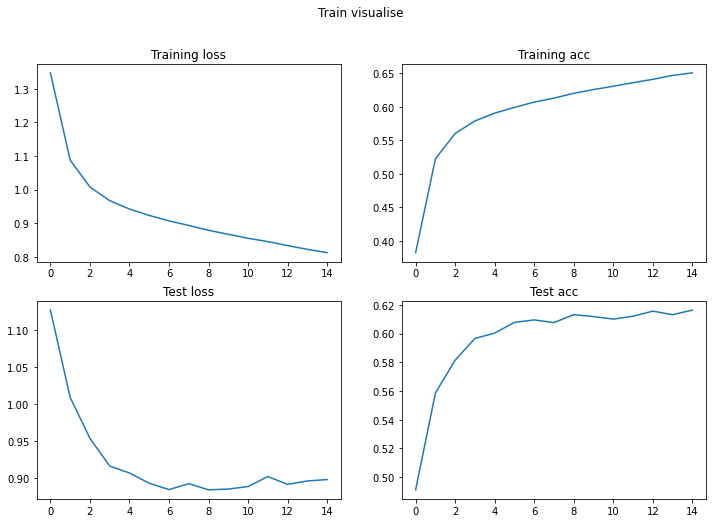

In [31]:
model_lstm =  LSTM(vocab_size, 50, 50)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.005)
#optimizer = optim.SGD(model_lstm.parameters(), lr=0.01, momentum=0.9)
#lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

model, training_losses, training_accs, test_losses, test_accuracies = train_model(model_lstm, optimizer, lrscheduler, epochs=15)
visual(training_losses, training_accs, test_losses, test_accuracies)

We see that the model has trained quite well, even an overfit begins. But the required accuracy has been achieved, so you can proceed to the implementation of the course project)